# Qiskit

In [22]:
!pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
from qiskit.algorithms import VQE
from qiskit import Aer, IBMQ
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.providers.aer.noise import NoiseModel
from qiskit.algorithms.optimizers import L_BFGS_B, COBYLA
from qiskit.tools.visualization import circuit_drawer
from qiskit.circuit.library import EfficientSU2  

seed = 9999
entanglement = "linear"

## preparing the hamiltonian for n quibts (Ising model)

In [24]:
import numpy as np
from qiskit.opflow import Z, I

def create_general_hamiltonian(S,doPrint=0):
  num_qubits = len(S)
  sum = 0
  sigmas_list = []
  for qubit in range(num_qubits):
    if qubit == 0:
       sigma = Z
    else:
       sigma = I
    for i in range(1,num_qubits):
      if i == qubit:
        sigma = sigma^Z
      else:
        sigma = sigma^I
    sigmas_list.append(sigma)  

  for i in range(len(sigmas_list)):
    for j in range(len(sigmas_list)):
      sum += S[i]*S[j]* sigmas_list[i]@sigmas_list[j]
  if doPrint:
    print("========== Ising Model Hamiltonian ==========\n")
    print(sum.to_matrix())
    print()
  return sum

## compute minimal eigenvalue

In [25]:
from qiskit.circuit.library import EfficientSU2

def minimum_eigenvalue_by_vqe(num_qubits, ansatz_entanglement, optimizer, quantum_instance, hamiltonian,doPrint=0):
    ansatz = EfficientSU2(num_qubits=num_qubits, entanglement=entanglement)
    #ansatz.draw(output='latex', scale=0.5)
    vqe = VQE(ansatz, optimizer, quantum_instance=quantum_instance)
    result = vqe.compute_minimum_eigenvalue(hamiltonian)
    if doPrint:
      print("minimal eigenvalue: ", format(result.eigenvalue,".3f"))
    return result.eigenvalue, result

## preparing the simulator

In [26]:
def prepare_simulator(simulator_name, optimizer_name, seed, shots=8192):
    algorithm_globals.random_seed = seed
    backend = Aer.get_backend(simulator_name)
    quantum_instance = QuantumInstance(backend=backend, 
                                      shots=shots, 
                                      seed_transpiler=seed, 
                                      seed_simulator=seed
                                      )
    if optimizer_name == "cobyla" or optimizer_name == "COBYLA":
      optimizer = COBYLA(maxiter=60)
    else:
      optimizer = L_BFGS_B(maxiter=60)
    return optimizer, quantum_instance

## Approximate

In [47]:
import numpy as np
    

def approximate_eigenvalue(result, H):
    eigenstate = result.eigenstate
    abs_eigenstate = abs(eigenstate).tolist()
    sorted_eigenstate = sorted(enumerate(abs_eigenstate), key=lambda i: i[1])
    max_index = sorted_eigenstate[-1][0]
    second_max_index = sorted_eigenstate[-2][0]
    mat = H.to_matrix()
    first_eigenvalue = mat[max_index][max_index]
    second_eigenvalue = mat[second_max_index][second_max_index]
    if (second_eigenvalue < first_eigenvalue):
        return second_eigenvalue
    return first_eigenvalue

## define parameters

In [48]:
avg_array_solvable = []
avg_array_solvable_approx = []
avg_array_unsolvable = []
avg_array_unsolvable_approx = []
avg = 0.0
sum = 0
entanglement = "linear"

## run test

In [49]:
def run_experiment(simulator,optimizer, num_qubits=2,problems = [], expected_results = [0,0,0,0], solvable = True):
  sum = 0
  sum_approx = 0
  bfgs_optimizer, quantum_instance = prepare_simulator(simulator, optimizer, seed) 
  for idx, problem in enumerate(problems):
    print("\nproblem: ", problem, end= ', ')
    H = create_general_hamiltonian(problem)
    result, all = minimum_eigenvalue_by_vqe(num_qubits, entanglement, bfgs_optimizer, quantum_instance, H)
    approximate_result = approximate_eigenvalue(all, H)
    print("minimal eigenvalue: ", result)
    print("approximate eigenvalue: ", approximate_result)
    sum += result - expected_results[idx] 
    sum_approx += approximate_result - expected_results[idx] 
  avg = sum / 4.0
  avg_approx = sum_approx / 4.0
  if(solvable):
    avg_array_solvable.append(avg)
    avg_array_solvable_approx.append(avg_approx)
  else:
    avg_array_unsolvable.append(avg)
    avg_array_unsolvable_approx.append(avg_approx)


In [50]:
def test_problem_instances(num_qubits=2, problems = [], expected_results = [0,0,0,0], solvable = True):
  print(f"simulator: aer_statevector, optimizer: bfgs, num of qubits: {num_qubits} ")     
  if( not solvable):                       
    r1 = run_experiment("aer_simulator_statevector","bfgs",num_qubits, problems[num_qubits-2], expected_results[num_qubits-2], solvable)
  else:                      
    r1 = run_experiment("aer_simulator_statevector","bfgs",num_qubits, problems[num_qubits-2], expected_results, solvable)  
  return r1

# Run experiments

## Solvable problems

In [51]:
solvable_problems_sets = [[[1,1],[2,2],[24,24],[0,0]],
                          [[0,1,1],[1,3,2],[7,4,3],[40,20,60]],
                          [[1,6,2,3],[8,2,4,2],[14,7,3,4],[7,1,5,3]],
                          [[2,3,5,4,6],[5,3,5,10,3],[4,7,3,7,7],[1,5,3,4,5]],
                          [[4,5,3,4,4,4],[7,5,7,9,9,1],[8,1,2,5,1,5],[4,7,4,5,5,5]],
                          [[4,5,4,5,4,8,6],[7,3,7,4,4,4,5],[8,1,2,5,6,6,4],[5,3,4,5,12,4,1]],
                          [[1,0,0,0,0,0,2,1],[1,2,3,4,10,0,0,0],[5,6,7,8,11,11,1,3],[5,3,4,2,10,1,1,2]],
                          [[1,6,2,0,1,2,6,2,0],[4,1,0,6,4,6,4,3,2],[2,1,0,4,5,7,3,1,1],[3,9,1,8,3,12,4,8,0]],
                          [[8,2,5,1,0,2,4,3,2,5],[6,8,4,2,9,5,5,9,6,4],[5,8,1,3,2,6,4,3,3,3],[6,4,3,0,8,10,6,4,1,0]]
                          ]

In [52]:
for i in range(2,11):
  test_problem_instances(num_qubits=i, problems = solvable_problems_sets,solvable=True)
  print(f"\nThe average deviation from the desired result of {i} quibit solvable instances is: ", avg_array_solvable[i-2])
  print()
  print(f"\nThe approximated average deviation from the desired result of {i} quibit solvable instances is: ", avg_array_solvable_approx[i-2])
  print("\n\n")

simulator: aer_statevector, optimizer: bfgs, num of qubits: 2 

problem:  [1, 1], minimal eigenvalue:  (6.9636e-14+0j)
approximate eigenvalue:  0j

problem:  [2, 2], minimal eigenvalue:  (8.572e-15+0j)
approximate eigenvalue:  0j

problem:  [24, 24], minimal eigenvalue:  (2.0699e-14+0j)
approximate eigenvalue:  0j

problem:  [0, 0], minimal eigenvalue:  0j
approximate eigenvalue:  0j

The average deviation from the desired result of 2 quibit solvable instances is:  (2.4726749999999997e-14+0j)


The approximated average deviation from the desired result of 2 quibit solvable instances is:  0j



simulator: aer_statevector, optimizer: bfgs, num of qubits: 3 

problem:  [0, 1, 1], minimal eigenvalue:  (1.1850255e-11+0j)
approximate eigenvalue:  0j

problem:  [1, 3, 2], minimal eigenvalue:  (1.5788477e-11+0j)
approximate eigenvalue:  0j

problem:  [7, 4, 3], minimal eigenvalue:  (8.49e-16+0j)
approximate eigenvalue:  0j

problem:  [40, 20, 60], minimal eigenvalue:  (1.27367162e-10+0j)
appro

## Unsolvable problems

In [53]:
unsolvable_problems_sets = [
    [[0,1],[1,2],[2,24],[23,25]],
    [[1,1,1],[1,4,6],[13,1,11],[21,56,87]],
    [[1,5,3,2],[8,6,4,5],[14,7,5,4],[7,3,4,3]],
    [[4,3,5,5,6],[5,4,4,10,2],[4,7,3,13,2],[2,4,4,4,5]],
    [[3,6,3,4,5,4],[6,5,8,9,8,1],[7,2,2,6,2,4],[6,7,2,5,4,5]],
    [[0,0,0,0,0,0,2],[1,2,3,4,10,1,0],[7,4,7,4,11,11,1],[5,3,4,6,16,1,2]],
    [[1,0,0,0,1,0,2,1],[1,2,3,4,11,0,2,2],[5,9,4,8,10,11,1,3],[6,2,4,2,9,1,1,2]],
    [[2,8,4,11,3,7,5,7,0],[2,0,6,3,5,1,4,1,3],[3,2,1,2,4,6,5,3,5],[2,5,2,0,1,2,6,3,0]],
    [[7,3,2,4,0,2,4,3,1,5],[5,9,4,2,9,5,5,8,6,4],[6,7,1,3,2,6,4,3,2,3],[5,5,2,1,8,9,6,4,1,0]],
]


expected_results = [
    [1,1,484,4],
    [1,1,1,100],
    [1,1,4,9],
    [1,1,1,1],
    [1,1,1,1],
    [4,1,1,1],
    [1,1,1,1],
    [1,1,1,1],
    [1,1,1,1],
]

In [54]:
for i in range(2,11):
  test_problem_instances(num_qubits=i, problems = unsolvable_problems_sets,expected_results=expected_results,solvable=False)
  print(f"\nThe average deviation from the desired result of {i} quibit unsolvable instances is: ", avg_array_unsolvable[i-2])
  print()
  print(f"\nThe approximated average deviation from the desired result of {i} quibit unsolvable instances is: ", avg_array_unsolvable_approx[i-2])
  print("\n\n")

simulator: aer_statevector, optimizer: bfgs, num of qubits: 2 

problem:  [0, 1], minimal eigenvalue:  (1+0j)
approximate eigenvalue:  (1+0j)

problem:  [1, 2], minimal eigenvalue:  (1.0000000000000082+0j)
approximate eigenvalue:  (1+0j)

problem:  [2, 24], minimal eigenvalue:  (484.00000000000057+0j)
approximate eigenvalue:  (484+0j)

problem:  [23, 25], minimal eigenvalue:  (4.0000000000000115+0j)
approximate eigenvalue:  (4+0j)

The average deviation from the desired result of 2 quibit unsolvable instances is:  (1.4704903961160198e-13+0j)


The approximated average deviation from the desired result of 2 quibit unsolvable instances is:  0j



simulator: aer_statevector, optimizer: bfgs, num of qubits: 3 

problem:  [1, 1, 1], minimal eigenvalue:  (1.0000000000000016+0j)
approximate eigenvalue:  (1+0j)

problem:  [1, 4, 6], minimal eigenvalue:  (1.0000000000006246+0j)
approximate eigenvalue:  (1+0j)

problem:  [13, 1, 11], minimal eigenvalue:  (1.0000000000003606+0j)
approximate eigen

# create the graphs

# solvable problems deviation from the desired result

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


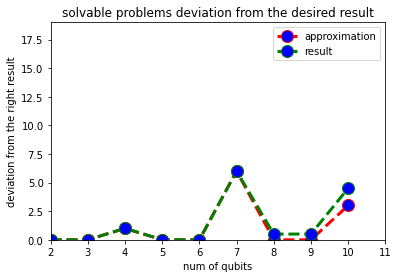

range(2, 11)
[(2.4726749999999997e-14+0j), (3.875168575e-11+0j), (1.0000000000051403+0j), (0.012224822918688646+0j), (0.00022124055204488974+0j), (6.000013608013472+0j), (0.5014507975191161+0j), (0.49963958938797043+0j), (4.500209625296283+0j)]


In [55]:
import matplotlib.pyplot as plt
  
# y axis values
y = avg_array_solvable
# corresponding x axis values
x = range(2,11)

z = avg_array_solvable_approx

plt.plot(x, z, color='red', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=12, label='approximation') 

# plotting the points 
plt.plot(x, y, color='green', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=12, label='result')


  
# setting x and y axis range
plt.ylim(0,19)
plt.xlim(2,11)

plt.legend()
  
# naming the x axis
plt.xlabel('num of qubits')
# naming the y axis
plt.ylabel('deviation from the right result')
  
# giving a title to my graph
plt.title('solvable problems deviation from the desired result')
  
# function to show the plot
plt.show()
print(x)
print(y)

# unsolvable problems deviation from the desired result

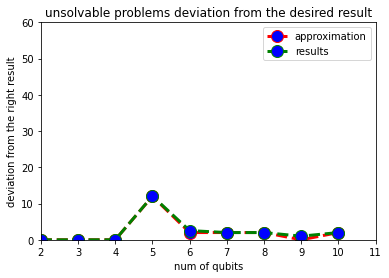

range(2, 11)
[(1.4704903961160198e-13+0j), (1.1283310064058583e-08+0j), (1.7641410909874367e-07+0j), (12.055662656736997+0j), (2.5392707409193203+0j), (2.0008454177537676+0j), (2.0000017115620983+0j), (1.000059703187121+0j), (2.0032890697071926+0j)]


In [56]:
import matplotlib.pyplot as plt
  
# y axis values
y = avg_array_unsolvable

z = avg_array_unsolvable_approx

# corresponding x axis values
x = range(2,11)

plt.plot(x, z, color='red', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=12, label='approximation')

# plotting the points 
plt.plot(x, y, color='green', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=12, label='results')


  
# setting x and y axis range
plt.ylim(0,60)
plt.xlim(2,11)
  
plt.legend()

# naming the x axis
plt.xlabel('num of qubits')
# naming the y axis
plt.ylabel('deviation from the right result')
  
# giving a title to my graph
plt.title('unsolvable problems deviation from the desired result')
  
# function to show the plot
plt.show()
print(x)
print(y)